<a href="https://colab.research.google.com/github/hasyachaudhary/gold-prise-pridiction/blob/main/gold_prise_pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima==2.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from scipy.stats import normaltest, ttest_1samp

In [ ]:
data = pd.read_csv('/content/goldstock.csv')

In [ ]:
data.head(10)


,Unnamed: 0,Date,Close,Volume,Open,High,Low
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
5,5,2024-01-11,2019.2,270624.0,2029.4,2056.1,2017.3
6,6,2024-01-10,2027.8,183625.0,2036.0,2046.2,2025.9
7,7,2024-01-09,2033.0,194610.0,2034.5,2048.6,2031.9
8,8,2024-01-08,2033.5,199325.0,2052.6,2053.3,2022.7
9,9,2024-01-05,2049.8,208861.0,2051.4,2071.1,2030.8


In [ ]:
data =data.iloc[::-1]#because data is from 2024 to 2014 so our model will predict 2013 data not 2025
data.shape
data.head()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
2510,2532,2014-01-22,1238.6,80262.0,1240.5,1243.5,1235.5
2509,2531,2014-01-23,1262.5,41697.0,1235.1,1267.1,1230.8
2508,2530,2014-01-24,1264.5,34998.0,1264.3,1273.2,1256.9
2507,2529,2014-01-27,1263.5,63419.0,1269.9,1280.1,1252.0
2506,2528,2014-01-28,1250.5,81426.0,1254.9,1261.9,1248.0


In [ ]:
data.isna().any()#there is no Na data in this datsate

Unnamed: 0    False
Date          False
Close         False
Volume        False
Open          False
High          False
Low           False
dtype: bool

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])#matplot consider date (without it it will not show year)

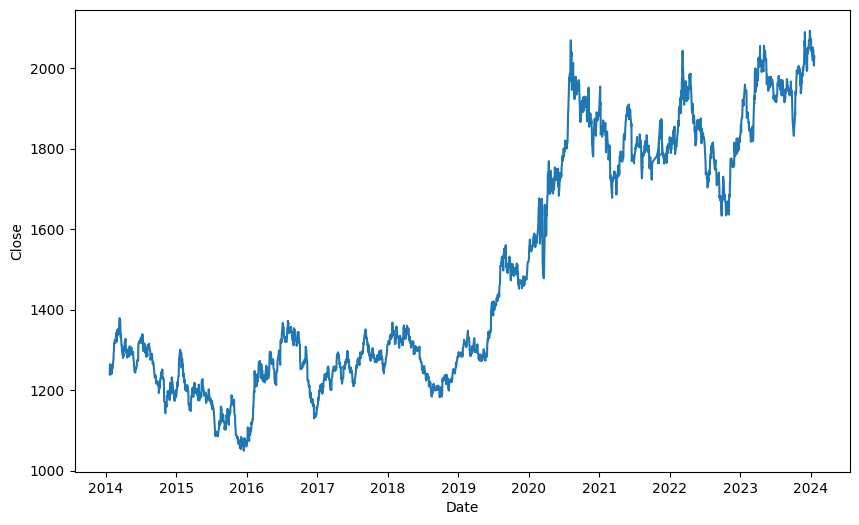

In [ ]:
#the trend
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(data['Date'],data['Close'])
plt.show()


1.  so from above we can see tha our data is **not stationary**



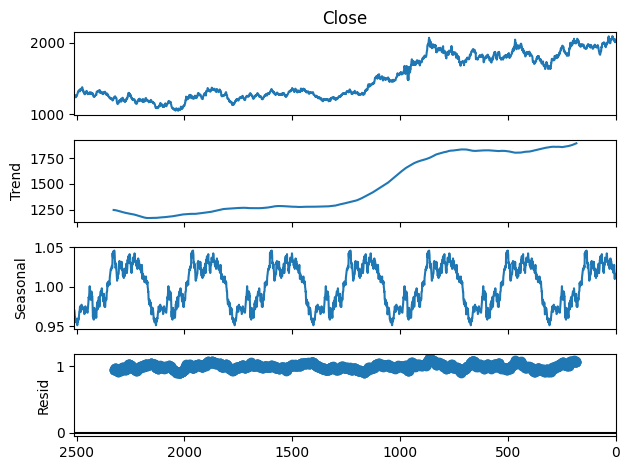

In [ ]:

#seasonality
# Perform seasonal decomposition
result = seasonal_decompose(data['Close'], model='multiplicative', period=365)  # Adjust period based on your data frequency

# Plot the decomposed components
result.plot()
plt.show()

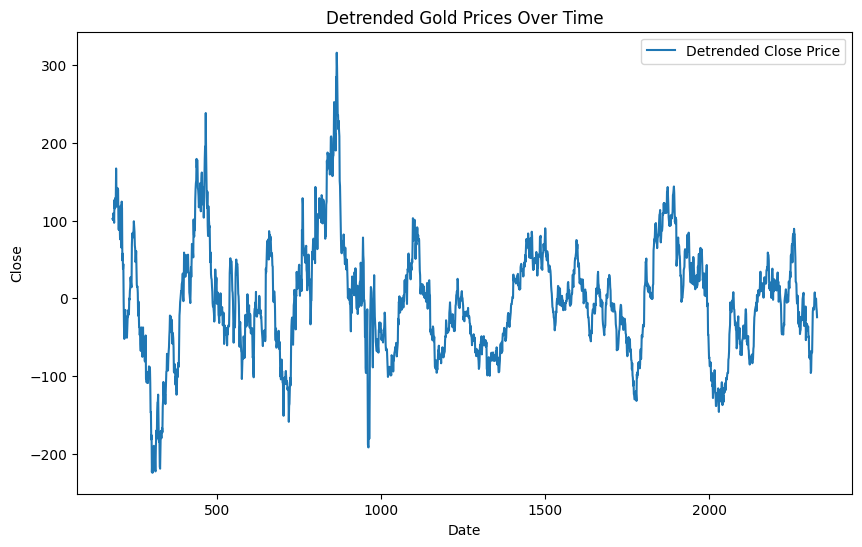

In [ ]:
trend = result.trend
#detrending the trend for cicalicy to show up beacause we can not see cicalicty in normal trend
# Detrend the data by subtracting the trend component
detrended = data['Close'] - trend

# Drop NaN values resulted from detrending
detrended = detrended.dropna()

# Plot the detrended data
plt.figure(figsize=(10, 6))
plt.plot(detrended, label='Detrended Close Price')
plt.title('Detrended Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

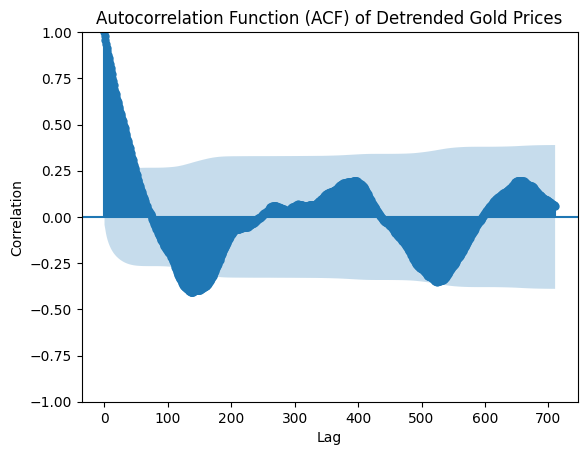

Dominant Frequency: 0.0027945971122496508
Dominant Period: 357.8333333333333 time units


In [ ]:
#we can see cyclicity after around 350 days
# Plot ACF of the detrended data
plt.figure(figsize=(10, 6))
plot_acf(detrended, lags=710)  # Adjust lags based on your data frequency
plt.title('Autocorrelation Function (ACF) of Detrended Gold Prices')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Perform Fourier Transform on the detrended data
fft_result = np.fft.fft(detrended)
fft_freq = np.fft.fftfreq(len(fft_result))

# Only take the positive half of the frequencies
positive_freqs = fft_freq[:len(fft_freq)//2]
positive_fft = np.abs(fft_result[:len(fft_result)//2])
dominant_frequency = positive_freqs[np.argmax(positive_fft)]
dominant_period = 1 / dominant_frequency

print(f"Dominant Frequency: {dominant_frequency}")
print(f"Dominant Period: {dominant_period} time units")

# ARIMA MODEL
Stap 1:  check the stationarity of the data

In [ ]:
msk=np.random.rand(len(data))<0.7
data_train=data[msk]
data_test=data[~msk]

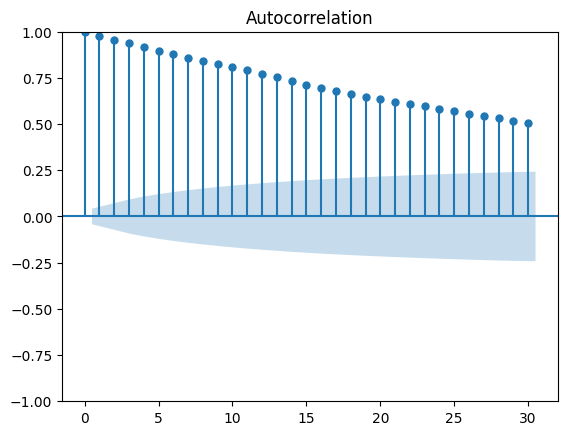

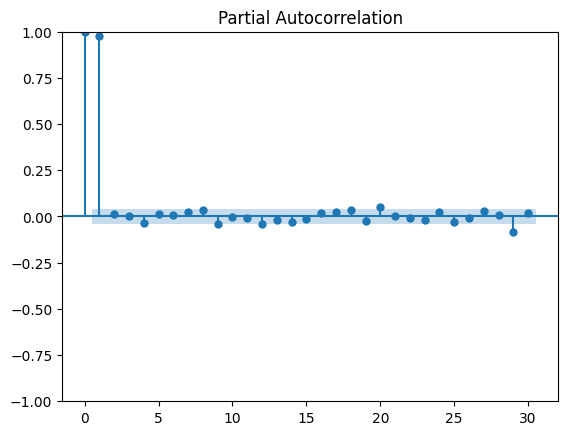

In [ ]:
#ACF and PACf plot
acf_plot = plot_acf(detrended, lags=30)
pacf_plot = plot_pacf(detrended, lags=30)


<Axes: >

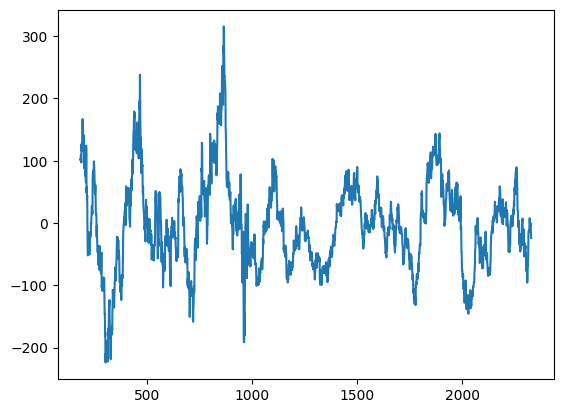

In [ ]:
#upper plot shows tha it is well known plot "random block" which is non statinary
detrended.plot()

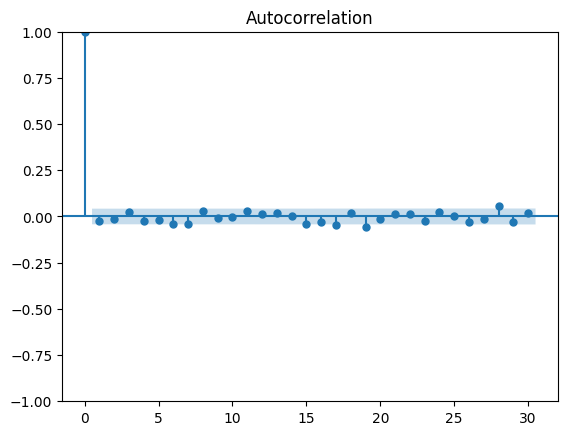

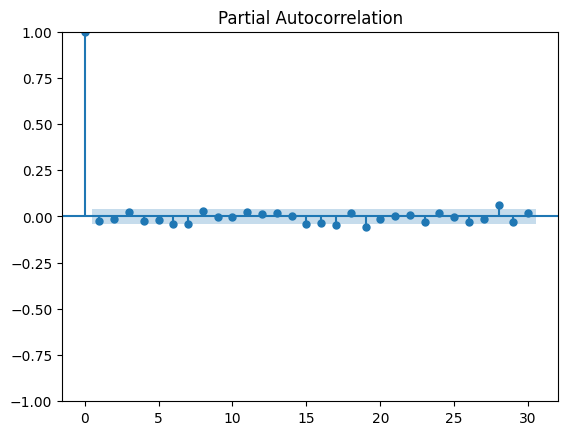

In [ ]:
acf_diff_plot = plot_acf(detrended.diff().dropna(), lags=30)
pacf_diff_plot = plot_pacf(detrended.diff().dropna(), lags=30)
#getting one spike in both graph so p and q will be same

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
arima_model = auto_arima(data['Close'],trace=True,suppress_warnings=True)
arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20602.863, Time=11.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20609.155, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20608.866, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20608.835, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20608.313, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20611.206, Time=2.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20610.987, Time=3.40 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=20606.437, Time=6.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=20612.301, Time=6.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20610.808, Time=1.92 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=20611.641, Time=2.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=20611.499, Time=2.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=20610.081, Time=8.96 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=20601.646, Time=2.11 sec
 ARIMA(1,1,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2511
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -10295.823
Date:                Wed, 26 Jun 2024   AIC                          20601.646
Time:                        11:01:32   BIC                          20630.786
Sample:                             0   HQIC                         20612.223
                               - 2511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3388      0.011   -122.348      0.000      -1.360      -1.317
ar.L2         -0.9813      0.011    -88.314      0.000      -1.003      -0.959
ma.L1          1.3252      0.015     90.274      0.000       1.296       1.354
ma.L2          0.9669      0.015     64.916      0.000       0.938       0.996
sigma2       213.9827      3.237     66.110      0.000     207.639     220.327
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):              2844.15
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Best model:  ARIMA(2,1,2)(0,0,0)[0] so no sisonality
model = ARIMA(data['Close'], order=(2,1,2))
model_fit = model.fit()

In [ ]:
print(data.shape)
print(data_train.shape)
print(data_test.shape)


(2511, 7)
(1751, 7)
(760, 7)


In [ ]:
start=len(data_train)
end=len(data_train)+len(data_test)-1
predictions = model_fit.predict(start=start, end=end, typ='levels')
print(predictions)

759    1907.711689
758    1912.317910
757    1838.948677
756    1848.248360
755    1844.019060
          ...     
4      2021.670389
3      2049.111387
2      2030.935639
1      2008.560080
0      2018.293159
Name: predicted_mean, Length: 760, dtype: float64


<Axes: >

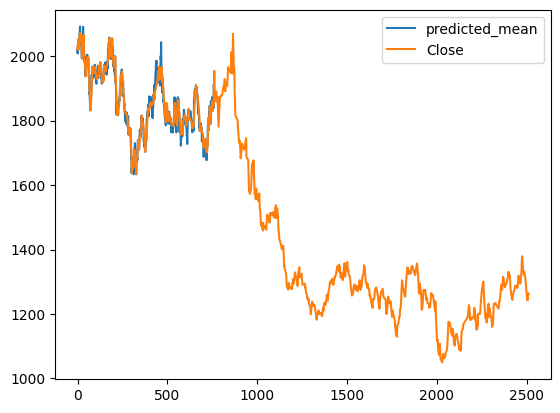

In [ ]:
predictions.plot(legend=True)
data_test['Close'].plot(legend=True)

In [ ]:
data_test['Close'].mean()

1516.9382894736843

In [ ]:
rmse = sqrt(mean_squared_error(data_test['Close'], predictions))
print (rmse)


433.1994684680701


In [ ]:
model2 = ARIMA(data['Close'], order=(2,1,2))
model2_fit = model2.fit()
data.tail()

,Unnamed: 0,Date,Close,Volume,Open,High,Low
4,4,2024-01-12,2051.6,250946.0,2033.2,2067.3,2033.1
3,3,2024-01-16,2030.2,277995.0,2053.4,2062.8,2027.6
2,2,2024-01-17,2006.5,245194.0,2031.7,2036.1,2004.6
1,1,2024-01-18,2021.6,167013.0,2009.1,2025.6,2007.7
0,0,2024-01-19,2029.3,166078.0,2027.4,2041.9,2022.2


In [ ]:
inedx_future_dates=pd.date_range(start='2024-01-20',end='2024-02-19')
pred=model2_fit.predict(start=len(data),end=len(data)+30,typ='levels').rename('ARIMA')
pred.index=inedx_future_dates
print(pred)
data.columns#next month value

2024-01-20    2031.369243
2024-01-21    2031.686160
2024-01-22    2029.231412
2024-01-23    2032.206779
2024-01-24    2030.632194
2024-01-25    2029.820588
2024-01-26    2032.452222
2024-01-27    2029.725465
2024-01-28    2030.793647
2024-01-29    2032.039259
2024-01-30    2029.323503
2024-01-31    2031.737006
2024-02-01    2031.170746
2024-02-02    2029.560560
2024-02-03    2032.271880
2024-02-04    2030.222057
2024-02-05    2030.305786
2024-02-06    2032.205105
2024-02-07    2029.580192
2024-02-08    2031.230620
2024-02-09    2031.596802
2024-02-10    2029.487066
2024-02-11    2031.952199
2024-02-12    2030.722154
2024-02-13    2029.949962
2024-02-14    2032.190746
2024-02-15    2029.948572
2024-02-16    2030.751534
2024-02-17    2031.876712
2024-02-18    2029.582440
2024-02-19    2031.549851
Freq: D, Name: ARIMA, dtype: float64


Index(['Unnamed: 0', 'Date', 'Close', 'Volume', 'Open', 'High', 'Low'], dtype='object')

In [ ]:
#Holt-Winters model
# Convert 'Close' column to numeric, forcing errors to NaN
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Drop rows with NaN values in 'Close' column
data.dropna(subset=['Close'], inplace=True)
# Build and fit Holt-Winters model
hw_model = ExponentialSmoothing(data_train['Close'], trend='add', seasonal='add', seasonal_periods=12)
hw_model_fit = hw_model.fit()

# Forecast
hw_forecast = hw_model_fit.forecast(steps=len(data_test))
hw_forecast = pd.Series(hw_forecast, index=data_test.index)

In [ ]:
#linear regration model
# Create lag features
def create_features(df):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_2'] = df['Close'].shift(2)
    df.dropna(inplace=True)
    return df

# Apply feature creation to train and test sets
train_lr = create_features(data_train)
test_lr = create_features(data_test)

# Define the feature columns and target variable
X_train = train_lr[['Lag_1', 'Lag_2']]
y_train = train_lr['Close']
X_test = test_lr[['Lag_1', 'Lag_2']]
y_test = test_lr['Close']

# Build and fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Forecast
lr_forecast = lr_model.predict(X_test)
lr_forecast = pd.Series(lr_forecast, index=y_test.index)

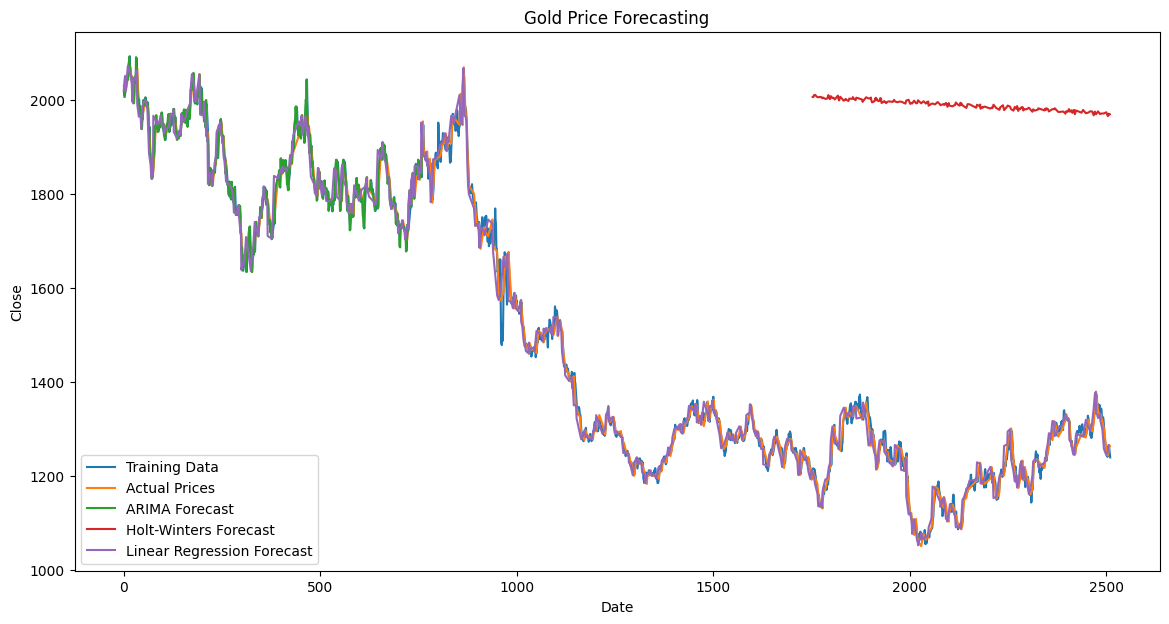

In [ ]:
#ploting all model to see which works better
plt.figure(figsize=(14, 7))
plt.plot(data_train['Close'], label='Training Data')
plt.plot(data_test['Close'], label='Actual Prices')
plt.plot(predictions, label='ARIMA Forecast')
plt.plot(hw_forecast, label='Holt-Winters Forecast')
plt.plot(lr_forecast, label='Linear Regression Forecast')
plt.title('Gold Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
#from upper plot we can says  arima works better
# Define the performance evaluation function
def evaluate_performance(actual, predicted, model_name):
    # Drop NaN values
    actual = actual.dropna()
    predicted = predicted.dropna()

    # Ensure alignment of indices
    actual, predicted = actual.align(predicted, join='inner')

    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)

    print(f'{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

evaluate_performance(data_test['Close'], predictions, 'ARIMA')
evaluate_performance(data_test['Close'], hw_forecast, 'Holt-Winters')
evaluate_performance(data_test['Close'], lr_forecast, 'Linear Regression')

ARIMA - MSE: 257.035992382752, RMSE: 16.032342074155977, MAE: 12.181413625241335
Holt-Winters - MSE: 597260.4120713928, RMSE: 772.8262496003825, MAE: 768.6882667189556
Linear Regression - MSE: 613.4144652343965, RMSE: 24.76720543853094, MAE: 17.401168251531985


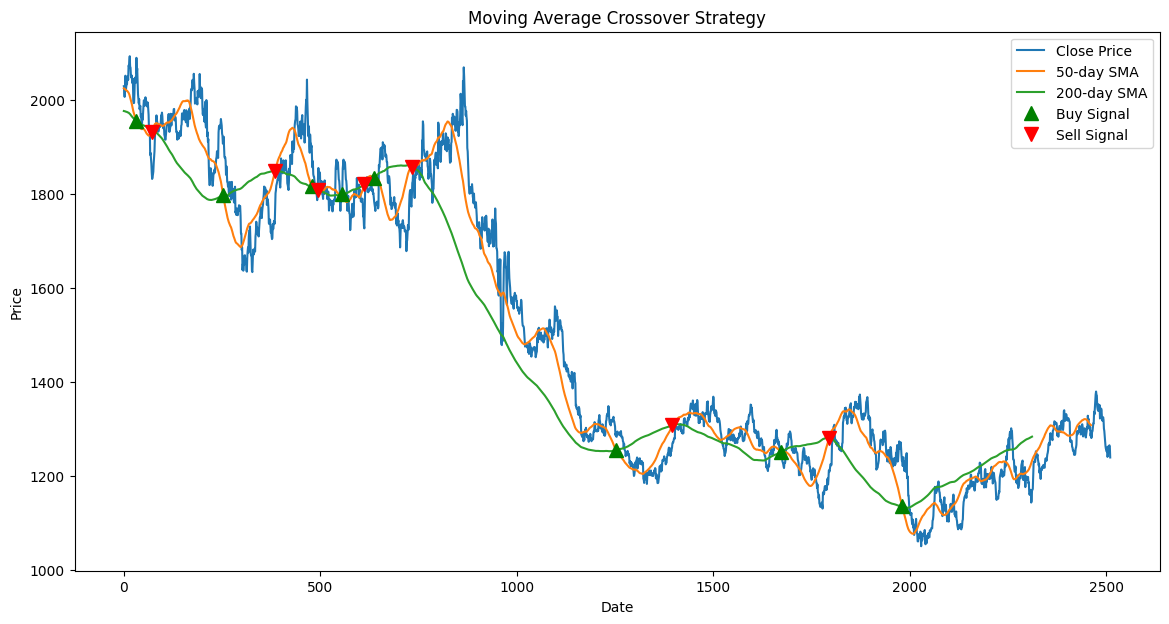

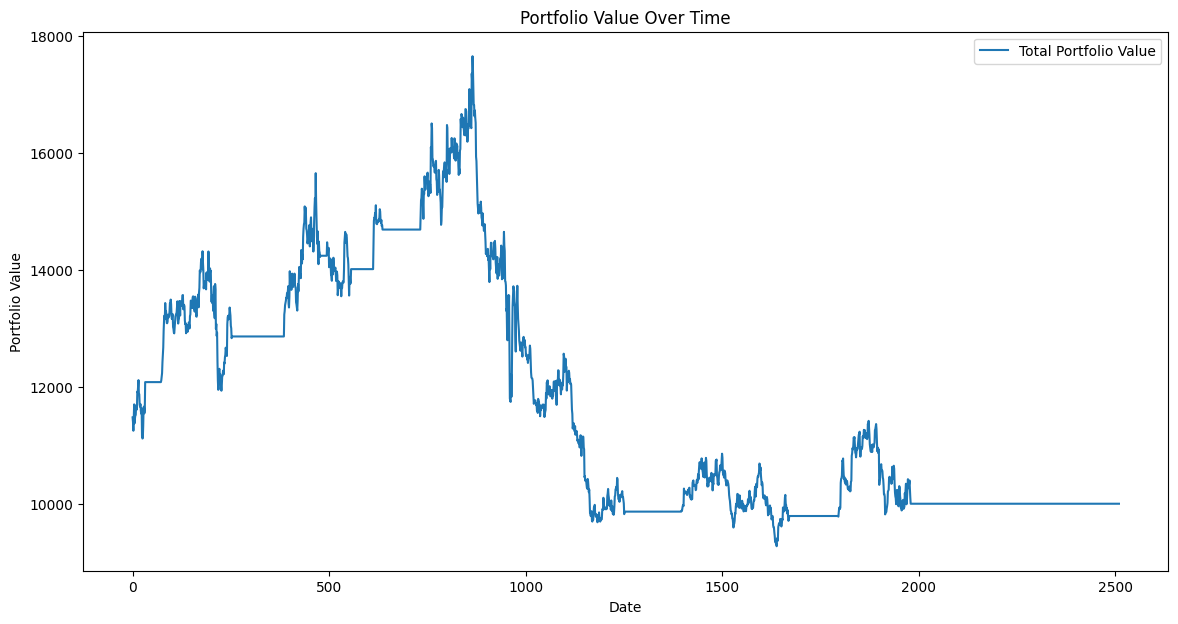

Final Portfolio Value:  11477.0


In [ ]:
#stretagy for when to buy and when to sell stocks
#and also profit calculation and representation in plot
# Calculate moving averages
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Generate signals up or down
data['Signal'] = 0
data['Signal'][50:] = np.where(data['SMA_50'][50:] > data['SMA_200'][50:], 1, 0)
data['Position'] = data['Signal'].diff()

# Plot signals
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_50'], label='50-day SMA')
plt.plot(data['SMA_200'], label='200-day SMA')
plt.plot(data[data['Position'] == 1].index, data['SMA_50'][data['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Position'] == -1].index, data['SMA_50'][data['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Backtesting
initial_capital = 10000
positions = pd.DataFrame(index=data.index).fillna(0.0)
positions['Gold'] = 10 * data['Signal']
portfolio = positions.multiply(data['Close'], axis=0)
pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(data['Close'], axis=0)).sum(axis=1)
portfolio['cash'] = initial_capital - (pos_diff.multiply(data['Close'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()

# Plot portfolio value
plt.figure(figsize=(14, 7))
plt.plot(portfolio['total'], label='Total Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

print('Final Portfolio Value: ', portfolio['total'].iloc[-1])


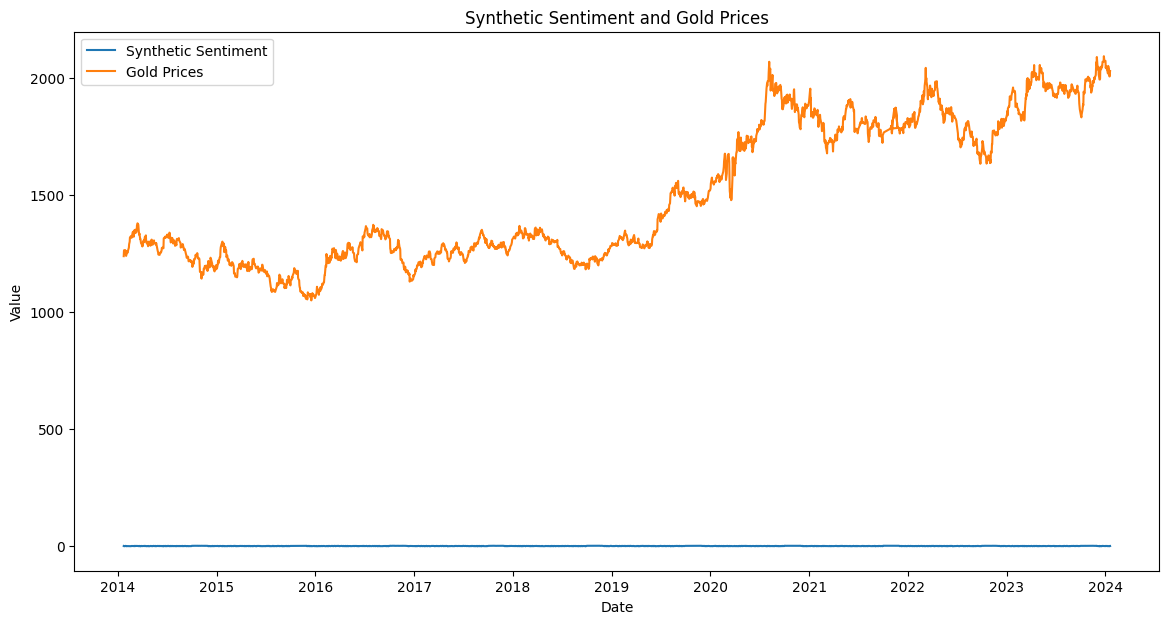

In [ ]:
#we want so see when data effect due to outside event
#we can see in diwali gold stock goese up
#so we are considaring month 10 and 11 for diwali
# Load gold prices dataset
gold_data = pd.read_csv('/content/goldstock.csv', parse_dates=['Date'], index_col='Date')

# Generate synthetic sentiment data
gold_data['Sentiment'] = gold_data.index.map(lambda date: np.random.uniform(0.5, 1.0) if date.month in [10, 11] else np.random.uniform(-1.0, 0.5))

# Calculate daily returns for gold prices
gold_data['Returns'] = gold_data['Close'].pct_change()

# Plot synthetic sentiment scores and gold prices
plt.figure(figsize=(14, 7))
plt.plot(gold_data['Sentiment'], label='Synthetic Sentiment')
plt.plot(gold_data['Close'], label='Gold Prices')
plt.title('Synthetic Sentiment and Gold Prices')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
# Summary statistics
summary_stats = gold_data.describe()
print("Summary Statistics:\n", summary_stats)


Summary Statistics:
         Unnamed: 0        Close         Volume         Open         High  \
count  2511.000000  2511.000000    2511.000000  2511.000000  2511.000000   
mean   1260.792911  1498.726085  185970.770609  1498.725528  1508.451454   
std     729.262879   298.824811   97600.769382   299.118187   301.262244   
min       0.000000  1049.600000       1.000000  1051.500000  1062.700000   
25%     630.500000  1249.850000  126693.500000  1249.500000  1257.300000   
50%    1259.000000  1332.800000  175421.000000  1334.000000  1342.400000   
75%    1888.500000  1805.850000  234832.000000  1805.600000  1815.450000   
max    2532.000000  2093.100000  787217.000000  2094.400000  2098.200000   

               Low    Sentiment      Returns  
count  2511.000000  2511.000000  2510.000000  
mean   1488.869932    -0.096654    -0.000153  
std     296.417703     0.547587     0.009331  
min    1045.400000    -0.999690    -0.056400  
25%    1242.350000    -0.568952    -0.005064  
50%    1326.

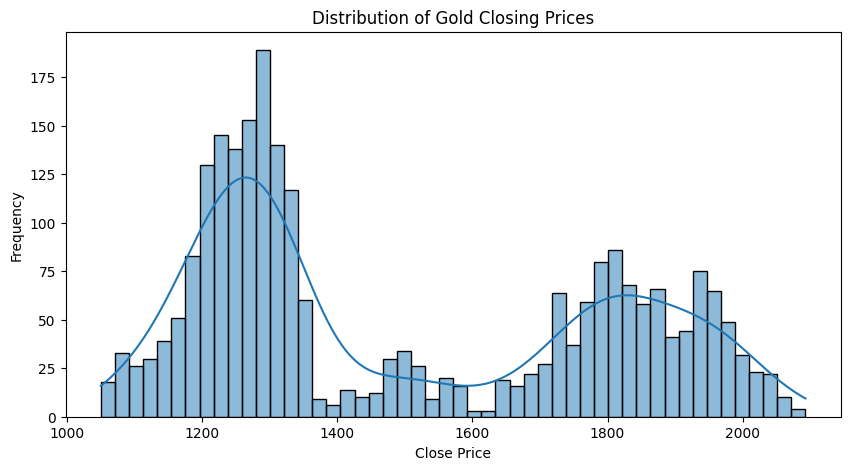

Normality Test:
Statistic: 20471.090775957284 p-value: 0.0


In [ ]:
# Distribution analysis: Histogram and normality test
plt.figure(figsize=(10, 5))
sns.histplot(gold_data['Close'], bins=50, kde=True)
plt.title('Distribution of Gold Closing Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# Normality test
stat, p = normaltest(gold_data['Close'].dropna())
print('Normality Test:')
print('Statistic:', stat, 'p-value:', p)

In [ ]:
# Generate synthetic external factors data (DXY and Crude Oil)
np.random.seed(0)
dates = gold_data.index

dxy_data = pd.DataFrame({
    'Date': dates,
    'DXY': np.random.uniform(90, 100, len(dates))
}).set_index('Date')

crude_oil_data = pd.DataFrame({
    'Date': dates,
    'Crude_Oil': np.random.uniform(40, 80, len(dates))
}).set_index('Date')

# Merge external factors with gold prices data
data = gold_data.join(dxy_data).join(crude_oil_data)

Correlation Matrix:
               Close       DXY  Crude_Oil
Close      1.000000 -0.005330   0.042516
DXY       -0.005330  1.000000  -0.007127
Crude_Oil  0.042516 -0.007127   1.000000


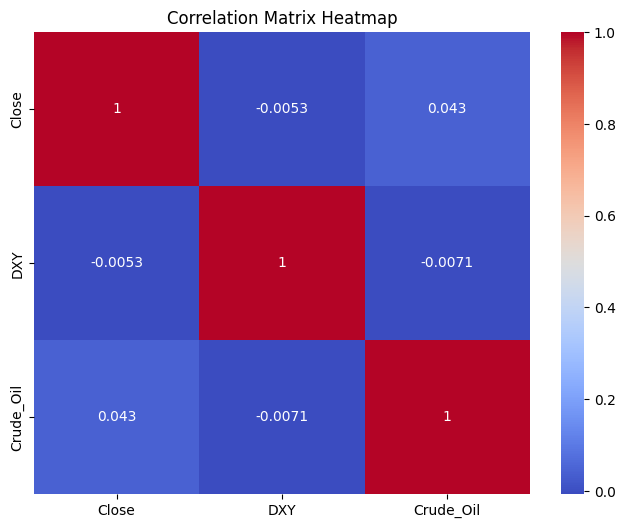

In [ ]:
# Compute correlations
correlation_matrix = data[['Close', 'DXY', 'Crude_Oil']].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()